## ALBERT's Cross-layer parameter sharing

In [1]:
from transformers import AlbertModel, AlbertTokenizer
import torch

In [2]:
model_nm = 'albert-large-v1'
tokenizer = AlbertTokenizer.from_pretrained(model_nm)
model = AlbertModel.from_pretrained(model_nm)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]

In [3]:
emb_output = model.embeddings(input_ids)

In [4]:
attention_mask = torch.ones(input_ids.shape)
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)  # fp16 compatibility
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

In [5]:
n_layers = model.encoder.config.num_hidden_layers
head_mask = [None] * n_layers

In [6]:
#trans = model.encoder(emb_output, extended_attention_mask, head_mask)

In [7]:
hidden_states = model.encoder.embedding_hidden_mapping_in(emb_output)
dist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
distance_list = []
for i in range(n_layers):
    input_embedding = hidden_states#.view(-1, 8*768)
    layer_out = model.encoder.albert_layer_groups[0](
        hidden_states,
        extended_attention_mask,
        head_mask[0*n_layers:(0+1)*n_layers]
    )
    hidden_states = layer_out[0]
    output_embedding = hidden_states
    
    distance = torch.dist(input_embedding, output_embedding, p=2)
    print(i, hidden_states.shape, input_embedding.shape, output_embedding.shape, distance)
    distance_list.append(distance)

0 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(39.1129, grad_fn=<DistBackward0>)
1 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(20.0344, grad_fn=<DistBackward0>)
2 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(16.1824, grad_fn=<DistBackward0>)
3 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(12.3042, grad_fn=<DistBackward0>)
4 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(9.8303, grad_fn=<DistBackward0>)
5 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(7.6768, grad_fn=<DistBackward0>)
6 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(6.3892, grad_fn=<DistBackward0>)
7 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(5.5773, grad_fn=<DistBackward0>)
8 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Si

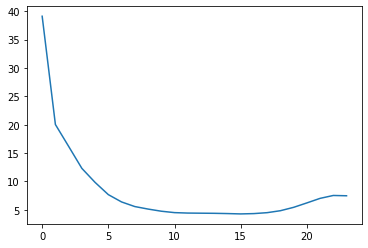

In [8]:
import matplotlib.pyplot as plt
plt.plot([d.detach().numpy() for d in distance_list])
plt.show()